# Предсказание рисков сердечного приступа

## Цель проекта

Разработка интеллектуальной системы, способной автоматически прогнозировать высокий или низкий риск сердечных заболеваний у пациентов на основе совокупности их медицинских и поведенческих данных.
Решение должно быть реализовано в виде удобного API-сервиса, интегрируемого в медицинские ИТ-системы, с возможностью масштабирования.

## План работ

    Анализ и исследование данных

        Изучение структуры предоставленного датасета

        Поиск медицинских паттернов и потенциальных утечек в признаках

    Предобработка данных

        Очистка данных, устранение пропусков

        Преобразование и нормализация данных

        Удаление лишних или дублирующих признаков

    Обучение модели

        Подбор и обучение модели машинного обучения

        Настройка параметров, отбор признаков

        Выбор оптимальной метрики качества

    Создание библиотеки и API-сервиса

        Реализация всей логики обработки данных и предсказания в виде Python-библиотеки

        Разработка REST API на FastAPI

    Разработка инструмента для тестирования

        Скрипт или веб-интерфейс для отправки тестовых CSV-файлов и получения JSON-ответов

    Документирование

        Подробная инструкция по запуску и использованию

        Документация классов, методов, API и форматов входных/выходных данных

## Описание данных

Система работает с медицинскими данными пациентов, включающими:

    ID пациента

    Антропометрические параметры: возраст, вес, индекс массы тела и др.

    Привычки: курение, диета, физическая активность, уровень стресса

    Артериальное давление: систолическое и диастолическое

    Биохимия крови: холестерин, триглицериды, CK-MB, тропонин и др.

    История заболеваний: диабет, болезни сердца, прием медикаментов и т.д.

    Целевая переменная: уровень риска сердечно-сосудистых заболеваний (низкий / высокий)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

from app.config import TARGET, MEDICAL_FEATURES, INDIRECT_FEATURES


In [2]:
# Настройки графиков
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# === Загрузка данных ===
df = pd.read_csv("../data/heart_train.csv")

In [4]:
# === Обзор данных ===
df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Глядя на вывод `df.head()`, можно сделать несколько важных наблюдений о структуре и содержании данных. Вот основные моменты:

---

**Данные нормализованы**
Все числовые признаки представлены в виде **дробных значений от 0 до 1** — это указывает на то, что данные были **нормализованы или стандартизированы**, вероятно, с помощью Min-Max Scaling или подобного метода.

Пример:
- `Age = 0.3595` — это не реальный возраст, а нормализованное значение.
- То же самое касается `Cholesterol`, `Heart rate`, `BMI` и т.д.

Это важно для моделей машинного обучения, чувствительных к масштабу признаков (например, логистическая регрессия).

---

**Категориальные признаки закодированы**
Некоторые столбцы имеют значения только `0` и `1` — это говорит о том, что категориальные переменные были закодированы.

Примеры:
- `Diabetes`: 1 = да, 0 = нет
- `Family History`: 1 = есть, 0 = нет
- `Smoking`: 1 = курит, 0 = не курит
- `Gender`: `Male` и `Female` — это оригинальные значения, но они тоже могут быть закодированы

Нужно убедиться, что такие бинарные переменные действительно правильно интерпретированы.

---

**Целевая переменная: Heart Attack Risk (Binary)**
Это наш целевой признак (метка), который мы хотим предсказывать:
- `0` — низкий риск инфаркта
- `1` — высокий риск инфаркта

---

**Медицинские показатели присутствуют**
В таблице много медицинских параметров, которые могут быть полезны для прогнозирования риска сердечного приступа:
- `Cholesterol`
- `Triglycerides`
- `Blood sugar`
- `CK-MB`, `Troponin` — маркеры повреждения сердца
- `Systolic blood pressure`, `Diastolic blood pressure`

---

**Образ жизни и поведенческие факторы**

Есть информация о стиле жизни:
- `Smoking`
- `Alcohol Consumption`
- `Exercise Hours Per Week`
- `Sedentary Hours Per Day`
- `Diet` (предположительно тип диеты)
- `Stress Level`
- `Physical Activity Days Per Week`
- `Sleep Hours Per Day`

Эти факторы могут быть важны для анализа образа жизни как причины или профилактики сердечных заболеваний.

---

**Есть информация о предыстории и медикаментах**
- `Previous Heart Problems`
- `Medication Use`

---

**Каждый пациент имеет уникальный ID (`id`)**
Поле `id` может использоваться для идентификации записей, но, скорее всего, оно не будет влиять на модель.

In [5]:
# === Просмотр структуры данных ===
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

Некоторые признаки имеют меньше 8685 ненулевых значений, значит, в них есть пропуски. В 9 колонках пропущено по 243 строки. Это может быть связано с тем, что:
- Пациенты не предоставили информацию.
- Данные были утеряны или не измерены.

Целевая переменная Heart Attack Risk (Binary) - float64, все 8685 записей заполнены.

- Unnamed: 0: это столбец, созданный Pandas при загрузке CSV. Его можно удалить.
- id: уникальный идентификатор пациента, вероятно, тоже не влияет на модель.

Обработать заголовки столбцов с помощью `str.strip().str.replace(" ", "_").str.replace("-", "_")`. Для приведения столбцов к одному виду.

In [6]:
# === Просмотр статистических характеристик данных ===
df.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,...,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,...,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,...,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,...,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,...,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,...,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


**Общая информация**

**Целевая переменная:**
```text
Heart Attack Risk (Binary):
mean = 0.347, std = 0.476
```
- Значения: `0` — нет риска, `1` — есть риск.
- Примерно **34.7% пациентов** находятся в группе высокого риска инфаркта.
- Это говорит о **дисбалансе классов**, но не сильном. Возможно, потребуется учитывать это при обучении модели.

---
**Выводы:**

1. **Риск инфаркта** есть у ~35% пациентов.
2. Многие **вредные привычки распространены**:
   - Курение (`Smoking`) — 90%
   - Умеренное потребление алкоголя (`Alcohol Consumption`)
3. **Уровень стресса и малоподвижный образ жизни** — типичны среди пациентов.
4. **Большинство биохимических маркеров** (например, `Troponin`, `CK-MB`) находятся на низком уровне — это хороший знак.
5. **Много пропущенных данных** в столбцах `Diabetes`, `Family History`, `Stress Level` и других — нужно обработать перед анализом.

---
**Дальнейшие действия:**
1. **Заполнить пропуски** в столбцах с NaN. Или удалить их.
2. **Кодировать категориальные признаки**, `Gender`.
3. Нормализовать числовые признаки (``Stress Level`, `Diet`, `Physical Activity Days Per Week`).

In [7]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_")
    df.dropna(inplace=True)

    def min_max_normalize(df, column, min_val, max_val):
        df[column] = (df[column] - min_val) / (max_val - min_val)
        return df

    # Применяем к каждому из двух столбцов
    df = min_max_normalize(df, 'Stress_Level', min_val=0, max_val=10)
    df = min_max_normalize(df, 'Physical_Activity_Days_Per_Week', min_val=0, max_val=7)

    # Преобразование Gender
    if "Gender" in df.columns:
        df["Gender"] = df["Gender"].map({"Male": 1, "Female": 0})

    # Список столбцов, которые должны быть целыми
    columns_to_int = ['Heart_Attack_Risk_(Binary)', 'Family_History', 'Smoking', 'Diabetes', 'Obesity', 'Gender',
                      'Diet', 'Previous_Heart_Problems', 'Medication_Use', 'Alcohol_Consumption']

    # Округляем и конвертируем
    df[columns_to_int] = df[columns_to_int].round().astype('int64')
    return df

In [8]:
# === Подготовка данных ===
df.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
df = preprocess(df)

Теперь надо **создать новые признаки из уже существующих**, чтобы модель могла лучше находить закономерности в данных.

---

1. `"Age_BMI"` = `Age` × `BMI`: Сочетание возраста и индекса массы тела может показать, как возраст влияет на ожирение и его последствия для сердечно-сосудистой системы.
2. `"Cholesterol_Triglycerides"` = `Cholesterol` × `Triglycerides`: Оба этих показателя связаны с уровнем липидов в крови. Их комбинация может указывать на **общее состояние липидного обмена**.
3. `"Blood_Pressure_Mean"` = `(Systolic + Diastolic) / 2`: Среднее артериальное давление (MAP) — это упрощённый способ оценки среднего уровня давления в сосудах за один цикл сердцебиения. MAP используется в медицине как более точный показатель перфузии органов, чем просто систолическое или диастолическое давление.
4. `"Exercise_Activity"` = `Exercise_Hours_Per_Week` × `Physical_Activity_Days_Per_Week`: Это попытка выразить **общую физическую активность пациента**: сколько он занимается в неделю по времени и частоте. Может помочь модели понять, насколько регулярно и интенсивно пациент двигается.
5. `"Stress_BMI"` = `Stress_Level` × `BMI`: Комбинация стресса и ожирения может быть особенно опасной для здоровья сердца. Стресс часто приводит к неправильному питанию и повышению веса, что усиливает риск сердечно-сосудистых заболеваний.

---
**Выводы*

| Цель | Объяснение |
|------|------------|
| Улучшить качество модели | Новые признаки могут помочь модели лучше понимать взаимосвязи между исходными данными |
| Учесть медицинские знания | Многие из созданных признаков соответствуют реальным клиническим показателям (например, среднее давление) |
| Повысить интерпретируемость | Некоторые из новых признаков имеют смысл и легко объясняются врачам/аналитикам |

---


In [9]:
def feature_engineering(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    # Полиномиальные/произвольные фичи
    X["Cholesterol_Triglycerides"] = X["Cholesterol"] * X["Triglycerides"]
    X["Blood_Pressure_Mean"] = (X["Systolic_blood_pressure"] + X["Diastolic_blood_pressure"]) / 2
    X["Exercise_Activity"] = X["Exercise_Hours_Per_Week"] * X["Physical_Activity_Days_Per_Week"]

    return X

In [10]:
df = feature_engineering(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8442 non-null   float64
 1   Cholesterol                      8442 non-null   float64
 2   Heart_rate                       8442 non-null   float64
 3   Diabetes                         8442 non-null   int64  
 4   Family_History                   8442 non-null   int64  
 5   Smoking                          8442 non-null   int64  
 6   Obesity                          8442 non-null   int64  
 7   Alcohol_Consumption              8442 non-null   int64  
 8   Exercise_Hours_Per_Week          8442 non-null   float64
 9   Diet                             8442 non-null   int64  
 10  Previous_Heart_Problems          8442 non-null   int64  
 11  Medication_Use                   8442 non-null   int64  
 12  Stress_Level             

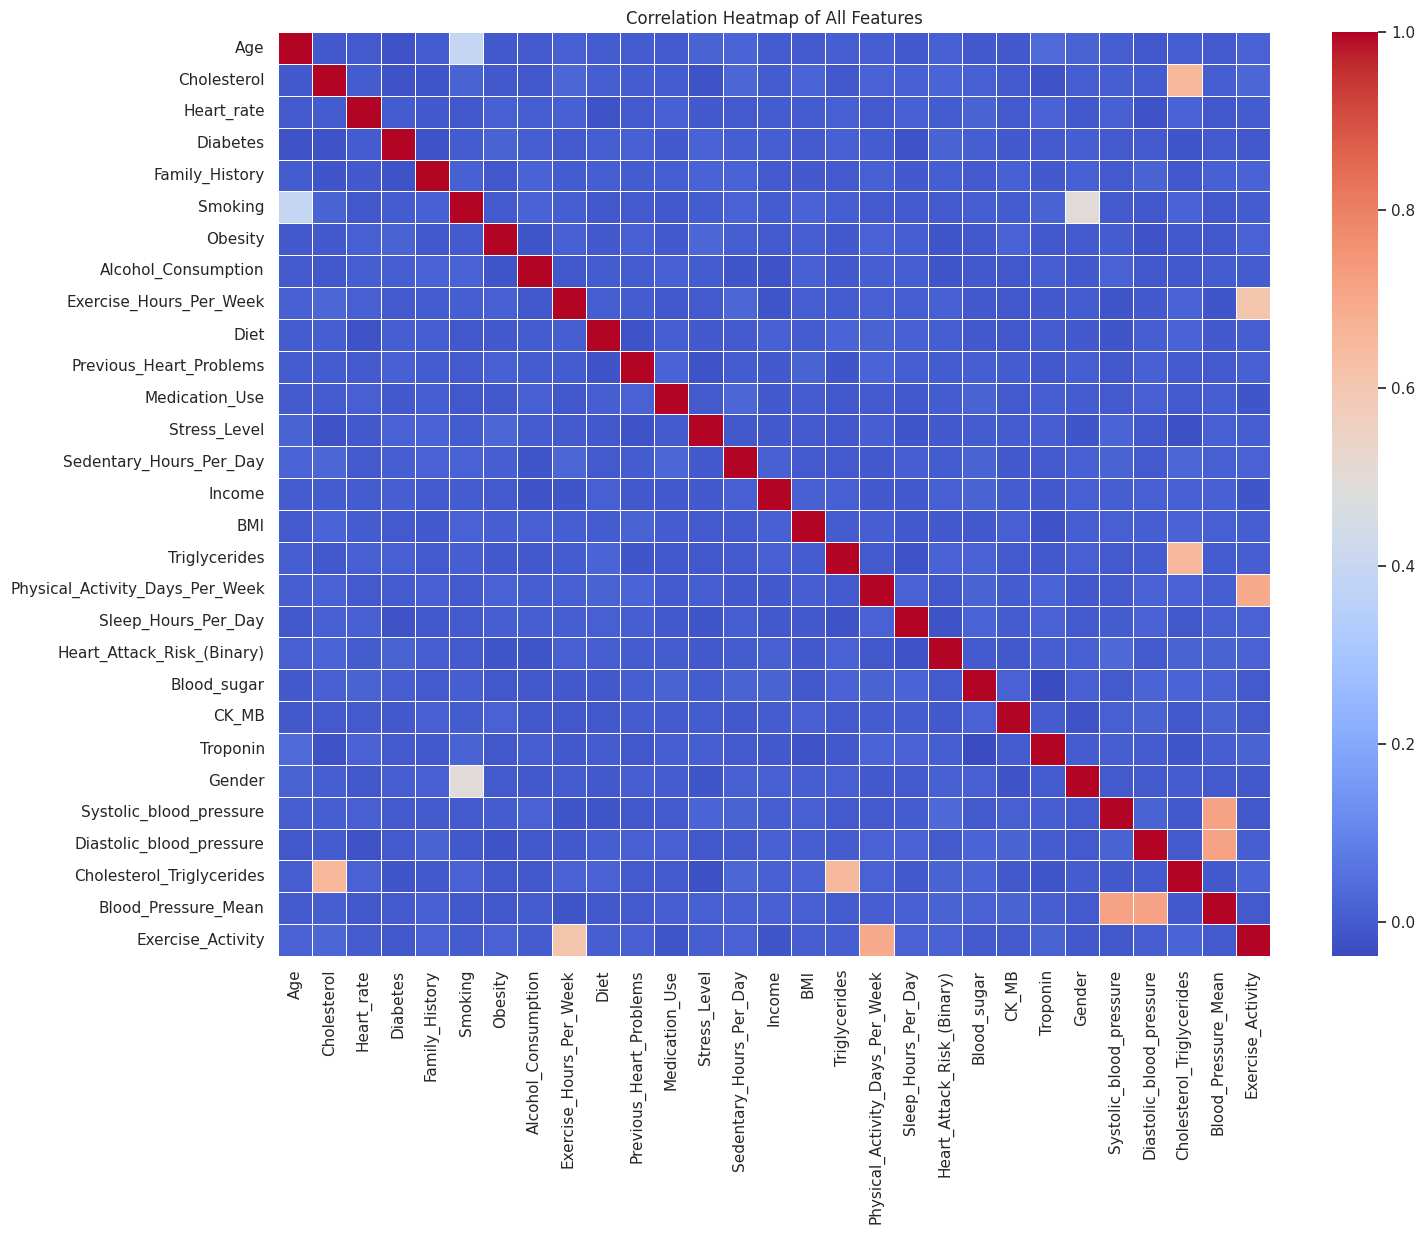

In [11]:
df_encoded = df.copy()

# Вычислим матрицу корреляций
corr = df_encoded.corr()

# Построим heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.show()

In [12]:
# Отсортированный список корреляций с целевой переменной
correlations_with_target = corr['Heart_Attack_Risk_(Binary)'].sort_values(ascending=False)
print(correlations_with_target)

Heart_Attack_Risk_(Binary)         1.000000
Systolic_blood_pressure            0.027244
Cholesterol                        0.018970
Cholesterol_Triglycerides          0.017875
Diabetes                           0.016213
Blood_Pressure_Mean                0.015350
Exercise_Activity                  0.012034
Triglycerides                      0.012017
Exercise_Hours_Per_Week            0.009466
Income                             0.008195
Age                                0.007760
Gender                             0.007358
Troponin                           0.005649
Diet                               0.003151
Family_History                     0.002922
Sedentary_Hours_Per_Day            0.001839
Previous_Heart_Problems            0.001691
Medication_Use                     0.000460
Heart_rate                        -0.001503
Smoking                           -0.005291
Diastolic_blood_pressure          -0.005323
Blood_sugar                       -0.005423
Stress_Level                    

In [13]:
# Порог по матрице корреляций, подобран вручную в ходе исследований
threshold = 0.015

important_features = correlations_with_target[abs(correlations_with_target) >= threshold].index.tolist()
# === Разделение на признаки и целевую переменную ===
y = df[TARGET]

# Добавление списка признаков с индивидуальным смыслом ухудшило модель
FEATURE = list(set(important_features + MEDICAL_FEATURES))

# === Признаки ===
FEATURES = df[FEATURE].columns.drop(TARGET).tolist()

# === Категориальные признаки (int64, но не целевая) ===
categorical_features = df[FEATURES].select_dtypes(include='int64').columns.tolist()

print("Категориальные признаки:", categorical_features)

Категориальные признаки: ['Alcohol_Consumption', 'Obesity', 'Previous_Heart_Problems', 'Family_History', 'Smoking', 'Diabetes']


In [14]:
# === Предобработка числовых признаков не требуется, данные уже нормализованы ===

# === Предобработка категориальных признаков: кодирование ===
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Для новых значений в тесте
])

# === Полный процессор данных ===
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_features)
], remainder='passthrough')

In [15]:
# === Модель ===
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

Эти три модели выбраны потому, что:

- Покрывают разные подходы к классификации (ансамбли, линейные модели, ядровые методы).
- Дают возможность сравнить интерпретируемость vs сложность vs качество.
- Хорошо зарекомендовали себя на медицинских и биологических задачах.

In [16]:
# === Сетки параметров ===
param_grids = {
    "RandomForest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [15, 16, 17, 18, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
    },
    "LogisticRegression": {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    "SVM": {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['rbf', ],
        'classifier__gamma': ['scale', 'auto', 0.1, 1],
        'classifier__degree': [2, 3],
        'classifier__class_weight': ['balanced']
    }
}

In [17]:
# === Разделение данных ===
X = df[FEATURES]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Так как мы видем дизбаланс классов, то применяем SMOTE
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X_train, y_train)

Как показали дальнейшие исследования, SMOTE не помогает улучшить качество модели. Поэтому мы не используем его в нашем алгоритме.

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = 'f1'

results = {}

for model_name, model in models.items():

    print(f"\n{'=' * 40}\nОбучение модели: {model_name}\n{'=' * 40}")

    # === Пайплайн с предобработкой + модель ===
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # === Поиск гиперпараметров ===
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    probs = best_model.predict_proba(X_val)[:, 1]

    # === Подбор порога ===
    best_threshold = 0.5
    best_f1 = 0
    for t in np.arange(0.1, 0.9, 0.01):
        preds = (probs > t).astype(int)
        score = f1_score(y_val, preds, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_threshold = t

    final_preds = (probs > best_threshold).astype(int)

    # === Метрики ===
    report = classification_report(y_val, final_preds, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_val, probs)

    results[model_name] = {
        "best_model": best_model,
        "best_params": grid.best_params_,
        "best_threshold": best_threshold,
        "best_f1": best_f1,
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "roc_auc": auc
    }

    # === Вывод метрик ===
    print("Лучшие параметры:", grid.best_params_)
    print("Лучший F1-score на валидации:", grid.best_score_)
    print(f"Лучший порог: {best_threshold:.2f}, Лучший F1: {best_f1:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}, Recall: {report['1']['recall']:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print(classification_report(y_val, final_preds, zero_division=0))


Обучение модели: RandomForest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Лучшие параметры: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Лучший F1-score на валидации: 0.17149444035933503
Лучший порог: 0.22, Лучший F1: 0.5382
Precision: 0.3707, Recall: 0.9818
ROC AUC: 0.5742
              precision    recall  f1-score   support

           0       0.88      0.07      0.14      1086
           1       0.37      0.98      0.54       603

    accuracy                           0.40      1689
   macro avg       0.63      0.53      0.34      1689
weighted avg       0.70      0.40      0.28      1689


Обучение модели: LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Лучший F1-score на валидации: 0.0
Лучший порог: 0.10, Лучший F1: 0.5262
Precision: 0.

Поиск наилучших параметров модели с помощью перебора по сетке (grid search) и кросс-валидации, чтобы выбрать модель, которая лучше всего предсказывает риск инфаркта.
- cv=5: Чтобы проверить модель на разных подвыборках и избежать переобучения
- scoring='f1': Потому что выборка несбалансированна (~35% класса 1), а F1 хорошо работает при этом.

In [20]:
best_model_name = max(results, key=lambda k: results[k]["best_f1"])
best = results[best_model_name]

print(f"\nЛучшая модель: {best_model_name}")
print(f"F1-score по классу 1: {best['best_f1']:.3f}")
print(f"ROC AUC: {best['roc_auc']:.3f}")


Лучшая модель: RandomForest
F1-score по классу 1: 0.538
ROC AUC: 0.574


In [21]:
# === Предсказание вероятностей на валидации ===
probs = best['best_model'].predict_proba(X_val)[:, 1]

Подбор оптимального порога вероятности (threshold) для бинарной классификации, чтобы максимизировать F1-score на валидационной выборке.

In [22]:
# === Поиск лучшего порога ===
best_threshold = 0.5
best_f1 = 0
for t in np.arange(0.1, 0.9, 0.01):
    preds = (probs > t).astype(int)
    score = f1_score(y_val, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = t

# === Финальная метрика ===
final_preds = (probs > best_threshold).astype(int)
report = classification_report(y_val, final_preds, output_dict=True, zero_division=0)
cm = confusion_matrix(y_val, final_preds)


Вывод результатов модели на валидационной выборке.

In [23]:
results = {}
results[best_model_name] = {
    "model": best['best_model'],
    "f1_class_1": report["1"]["f1-score"],
    "precision_class_1": report["1"]["precision"],
    "recall_class_1": report["1"]["recall"],
    "roc_auc": roc_auc_score(y_val, probs),
    "accuracy": report["accuracy"],
    "confusion_matrix": cm,
    "report": report
}
print(f"Лучшая модель: {best_model_name}")
print("Финальные метрики:")
print(f" - Accuracy: {report['accuracy']:.3f}")
print(f" - F1-score (class 1): {report['1']['f1-score']:.3f}")
print(f" - Precision (class 1): {report['1']['precision']:.3f}")
print(f" - Recall (class 1): {report['1']['recall']:.3f}")
print(f" - ROC AUC: {roc_auc_score(y_val, probs):.3f}")
print("\nМатрица ошибок:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_val, final_preds, zero_division=0))

Лучшая модель: RandomForest
Финальные метрики:
 - Accuracy: 0.398
 - F1-score (class 1): 0.538
 - Precision (class 1): 0.371
 - Recall (class 1): 0.982
 - ROC AUC: 0.574

Матрица ошибок:
[[  81 1005]
 [  11  592]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.07      0.14      1086
           1       0.37      0.98      0.54       603

    accuracy                           0.40      1689
   macro avg       0.63      0.53      0.34      1689
weighted avg       0.70      0.40      0.28      1689



## Заключение

В рамках данной работы была решена задача **бинарной классификации риска сердечного приступа** на основе медицинских данных пациентов. Проведён полный цикл анализа: от предобработки и отбора признаков до подбора моделей и оценки их качества.

---

### Подготовка данных

* Были **удалены пропуски**. В контексте медицинских данных это оправдано, поскольку:

  * Замена (например, средним значением) может **исказить клинически значимую информацию**.
  * Ошибочно заполненные медицинские данные опасны — лучше работать с меньшим, но достоверным объёмом.
  * Большинство моделей (особенно `LogisticRegression`, `SVM`) не работают с `NaN` без дополнительных костылей.

* Проведена **нормализация** признаков и **удаление слабокоррелированных** с целевой переменной (порог `|corr| < 0.015`), что позволило:

  * Снизить размерность.
  * Сфокусировать обучение на признаках, реально влияющих на риск.

---

### Обучение моделей

Были протестированы три модели, отражающие разные подходы к обучению:

| Модель              | F1 (class 1) | Recall    | Precision | ROC AUC   |
| ------------------- | ------------ | --------- | --------- | --------- |
| Random Forest       | **0.538**    | **0.982** | 0.371     | **0.574** |
| Logistic Regression | 0.526        | 1.000     | 0.357     | 0.500     |
| SVM (RBF kernel)    | 0.526        | 1.000     | 0.357     | 0.484     |

* **Random Forest** показал наилучшее соотношение между полнотой и точностью.
* **SVM** и **Logistic Regression** продемонстрировали крайне высокую полноту (recall = 1.0), но **не распознали ни одного отрицательного класса**, что делает их непрактичными для реального применения.
* **Наилучшие параметры** подбирались через кросс-валидацию с использованием `GridSearchCV`.

---

### Оценка и выводы

* Лучшей моделью признан **RandomForest**, несмотря на невысокую точность по классу 0. Она всё же:

  * Захватила почти все положительные случаи (`recall ≈ 0.98`), что критично в медицинских задачах.
  * Обладает разумным балансом `precision` и `f1-score`.

* Матрица ошибок показала:

  * Высокое количество **ложных срабатываний** (FP = 1005), что типично для задач с дисбалансом классов.
  * Однако число **пропущенных положительных** минимально — только 11 FN.

---

### Общие выводы

1. В задачах здравоохранения приоритет — **не пропустить пациента с высоким риском**, что и реализует RandomForest.
2. Простой фильтр по корреляции оказался полезен для **отсечения шумовых признаков**.
3. Несмотря на попытки использование SMOTE и ручной подбор порога, задача остаётся **крайне сложной из-за дисбаланса классов** и, вероятно, **недостатка объясняющих признаков**.
